In [100]:
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Audio processing
import librosa
import librosa.display

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, class_weight

# Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [101]:
def load_dataset(path, label_mapping):
    """
    Recursively load .wav files from 'path', assign labels based on 'label_mapping'.
    Files containing any key in label_mapping will be assigned the corresponding label.
    Unmatched or unlabelled files are skipped.
    """
    if not os.path.exists(path):
        print(f"Warning: Directory {path} not found.")
        return pd.DataFrame()

    # find all .wav files under path
    pattern = os.path.join(path, "**", "*.wav")
    wav_files = glob.glob(pattern, recursive=True)
    if not wav_files:
        print(f"Warning: No .wav files found in {path}")
        return pd.DataFrame()

    data = []
    for f in wav_files:
        fname = os.path.basename(f).lower()
        # skip unlabelled
        if "unlabelled" in fname:
            continue
        # determine label
        label = None
        for key, mapped in label_mapping.items():
            if key in fname:
                label = mapped
                break
        if label is None:
            continue
        # get duration
        try:
            dur = librosa.get_duration(path=f)
        except Exception:
            continue
        # slice into overlapping segments
        if dur >= 3:
            slice_dur, stride = 3.0, 1.5  # 50% overlap
            num = max(1, int((dur - slice_dur) / stride) + 1)
            for i in range(num):
                offset = min(i * stride, dur - slice_dur)
                data.append({"filename": f, "label": label, "offset": offset})
        else:
            data.append({"filename": f, "label": label, "offset": 0.0})

    df = pd.DataFrame(data)
    return shuffle(df, random_state=42) if not df.empty else df

In [102]:
def extract_features(audio_path, offset, duration=3):
    """Extract MFCC features from an audio file with consistent dimensions."""
    # Load audio file with specified offset and duration
    y, sr = librosa.load(audio_path, offset=offset, duration=duration)

    # Ensure audio is exactly the expected duration by padding with zeros or trimming
    expected_length = int(duration * sr)
    if len(y) < expected_length:
        # Pad with zeros if shorter than expected
        y = np.pad(y, (0, expected_length - len(y)), "constant")
    elif len(y) > expected_length:
        # Trim if longer than expected
        y = y[:expected_length]

    # Generate mel spectrogram with fixed time and frequency dimensions
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
    )

    # Generate MFCCs from mel spectrogram
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

    # Ensure consistent time dimension (frames)
    target_frames = (
        130  # This should be consistent for 3 second clips with hop_length=512
    )
    if mfccs.shape[1] < target_frames:
        # Pad if too short
        padding = ((0, 0), (0, target_frames - mfccs.shape[1]))
        mfccs = np.pad(mfccs, padding, mode="constant")
    elif mfccs.shape[1] > target_frames:
        # Trim if too long
        mfccs = mfccs[:, :target_frames]

    return mfccs


In [103]:
def visualize_dataset(df, samples=1):
    if df.empty:
        print("No data to visualize.")
        return

    labels = df.label.unique()

    for lbl in labels:
        subset = df[df.label == lbl].iloc[:samples]
        for idx, row in enumerate(subset.iterrows()):
            _, row_data = row
            y, sr = librosa.load(row_data.filename, offset=row_data.offset, duration=3)

            # Create a new figure for this sample with 3 subplots
            plt.figure(figsize=(18, 15))

            # Plot waveform
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(y=y, sr=sr)
            plt.title(f"{lbl} Waveform", fontsize=16)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("Amplitude", fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)

            # Plot melspectrogram
            plt.subplot(3, 1, 2)
            S = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
            )
            librosa.display.specshow(
                librosa.power_to_db(S, ref=np.max), sr=sr, x_axis="time", y_axis="mel"
            )
            plt.colorbar(format="%+2.0f dB")
            plt.title(f"{lbl} MelSpec", fontsize=16)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("Mel Bands", fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)

            # Plot MFCC
            plt.subplot(3, 1, 3)
            mf = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
            librosa.display.specshow(mf, x_axis="time")
            plt.colorbar()
            plt.title(f"{lbl} MFCC", fontsize=16)
            plt.xlabel("Time", fontsize=14)
            plt.ylabel("MFCC Coefficients", fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)

            plt.tight_layout(pad=3.0)
            plt.subplots_adjust(hspace=0.3)
            plt.show()

In [104]:
def train_model():
    # Define label mappings for datasets
    map_a = {
        "normal": "normal",
        "murmur": "murmur",
        "extrahls": "extrahls",
        "artifact": "artifact",
    }
    map_b = {"normal": "normal", "murmur": "murmur", "extrastole": "extrasystole"}

    # Load and combine datasets
    df_a = load_dataset("data/set_a", map_a)
    df_b = load_dataset("data/set_b", map_b)
    df = pd.concat([df_a, df_b], ignore_index=True)
    if df.empty:
        print("No data loaded.")
        return
    print(f"Loaded {len(df)} segments across dataset.")
    print(df.label.value_counts())

    # Visualize class distribution
    plt.figure(figsize=(10, 6))

    class_colors = {
        "normal": "green",
        "murmur": "red",
        "extrahls": "blue",
        "artifact": "purple",
        "extrasystole": "orange",
    }

    counts = df.label.value_counts()

    ax = counts.plot(
        kind="bar",
        title="Combined Distribution",
        color=[class_colors.get(lbl, "gray") for lbl in counts.index],
    )

    for i, v in enumerate(counts):
        ax.text(i, v + 5, str(v), ha="center", fontweight="bold")

    plt.xlabel("Heart Sound Classes")
    plt.ylabel("Number of Samples")
    plt.tight_layout()
    plt.show()

    visualize_dataset(df)

    # Data preparation
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df.label
    )
    print(f"Train: {len(train_df)}, Test: {len(test_df)}")

    X_train = np.array(
        [
            extract_features(r.filename, r.offset)
            for _, r in tqdm(train_df.iterrows(), total=len(train_df))
        ]
    )
    X_test = np.array(
        [
            extract_features(r.filename, r.offset)
            for _, r in tqdm(test_df.iterrows(), total=len(test_df))
        ]
    )

    # Label encoding and class weights
    encoder = LabelEncoder()
    encoder.fit(train_df.label)
    y_train = encoder.transform(train_df.label)
    y_test = encoder.transform(test_df.label)
    cw_vals = class_weight.compute_class_weight(
        "balanced", classes=np.unique(y_train), y=y_train
    )
    cw = {i: cw_vals[i] for i in range(len(cw_vals))}
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Model architecture
    model = Sequential(
        [
            Conv2D(32, 3, activation="relu", input_shape=X_train.shape[1:]),
            MaxPooling2D(),
            Dropout(0.2),
            Conv2D(64, 3, activation="relu"),
            MaxPooling2D(),
            Dropout(0.2),
            Conv2D(128, 3, activation="relu"),
            MaxPooling2D(),
            Dropout(0.3),
            Conv2D(256, 3, activation="relu"),
            GlobalAveragePooling2D(),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(len(encoder.classes_), activation="softmax"),
        ]
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"],
    )
    model.summary()

    # Training setup
    os.makedirs("model", exist_ok=True)
    cp = ModelCheckpoint(
        "model/heartbeat_classifier_best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1,
    )
    es = EarlyStopping("val_loss", patience=20, restore_best_weights=True)

    # Model training
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=100,
        callbacks=[cp, es],
        class_weight=cw,
        shuffle=True,
    )

    # Visualization of training metrics
    plt.figure(figsize=(18, 8))

    plt.subplot(121)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="validation")
    plt.legend()
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")

    plt.subplot(122)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="validation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

    # Model evaluation
    loss, acc = model.evaluate(X_test, y_test)
    print("Test loss:", loss, "Accuracy:", acc)
    preds = model.predict(X_test)
    y_true = encoder.inverse_transform(np.argmax(y_test, axis=1))
    y_pred = encoder.inverse_transform(np.argmax(preds, axis=1))
    print(classification_report(y_true, y_pred))

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred, labels=encoder.classes_)
    plt.figure(figsize=(10, 8))

    row_sums = np.sum(cm, axis=1)

    cm_percentages = np.zeros_like(cm, dtype=float)
    for i in range(len(encoder.classes_)):
        if row_sums[i] > 0:
            cm_percentages[i, i] = (cm[i, i] / row_sums[i]) * 100

    plt.imshow(cm, cmap="Blues")
    plt.colorbar(label="Count")
    plt.xticks(range(len(encoder.classes_)), encoder.classes_, rotation=45)
    plt.yticks(range(len(encoder.classes_)), encoder.classes_)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] == 0:
                continue

            text_color = "white" if cm[i, j] > cm.max() / 2 else "black"

            if i == j:
                plt.text(
                    j,
                    i,
                    f"{cm[i, j]}/{row_sums[i]} ({cm_percentages[i, j]:.1f}%)",
                    ha="center",
                    va="center",
                    color=text_color,
                )
            else:
                plt.text(
                    j, i, f"{cm[i, j]}", ha="center", va="center", color=text_color
                )

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Save model
    model.save("model/heartbeat_classifier_final.keras")

Loaded 1964 segments across dataset.
label
normal          1084
murmur           496
artifact         200
extrasystole     117
extrahls          67
Name: count, dtype: int64


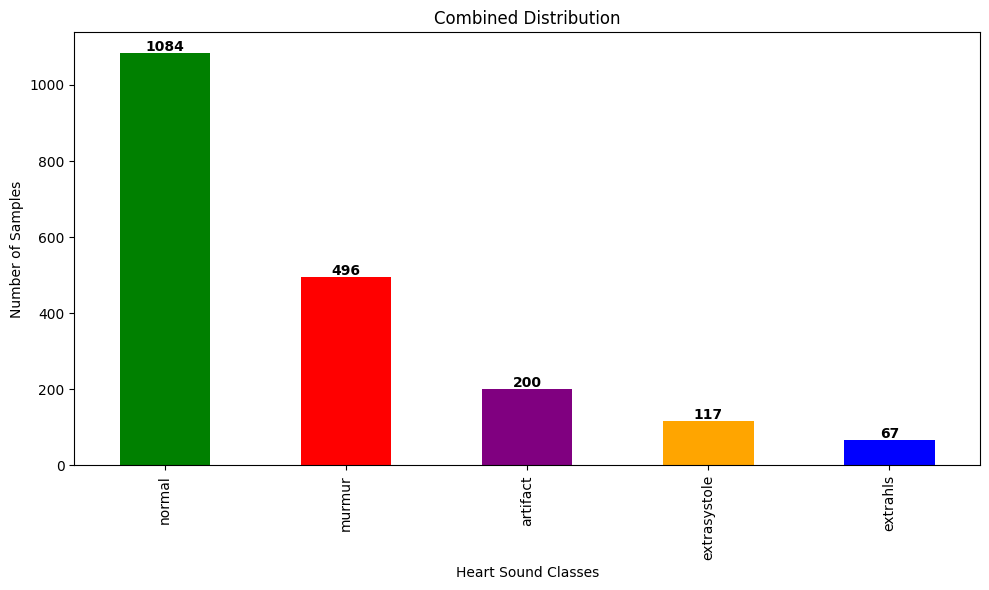

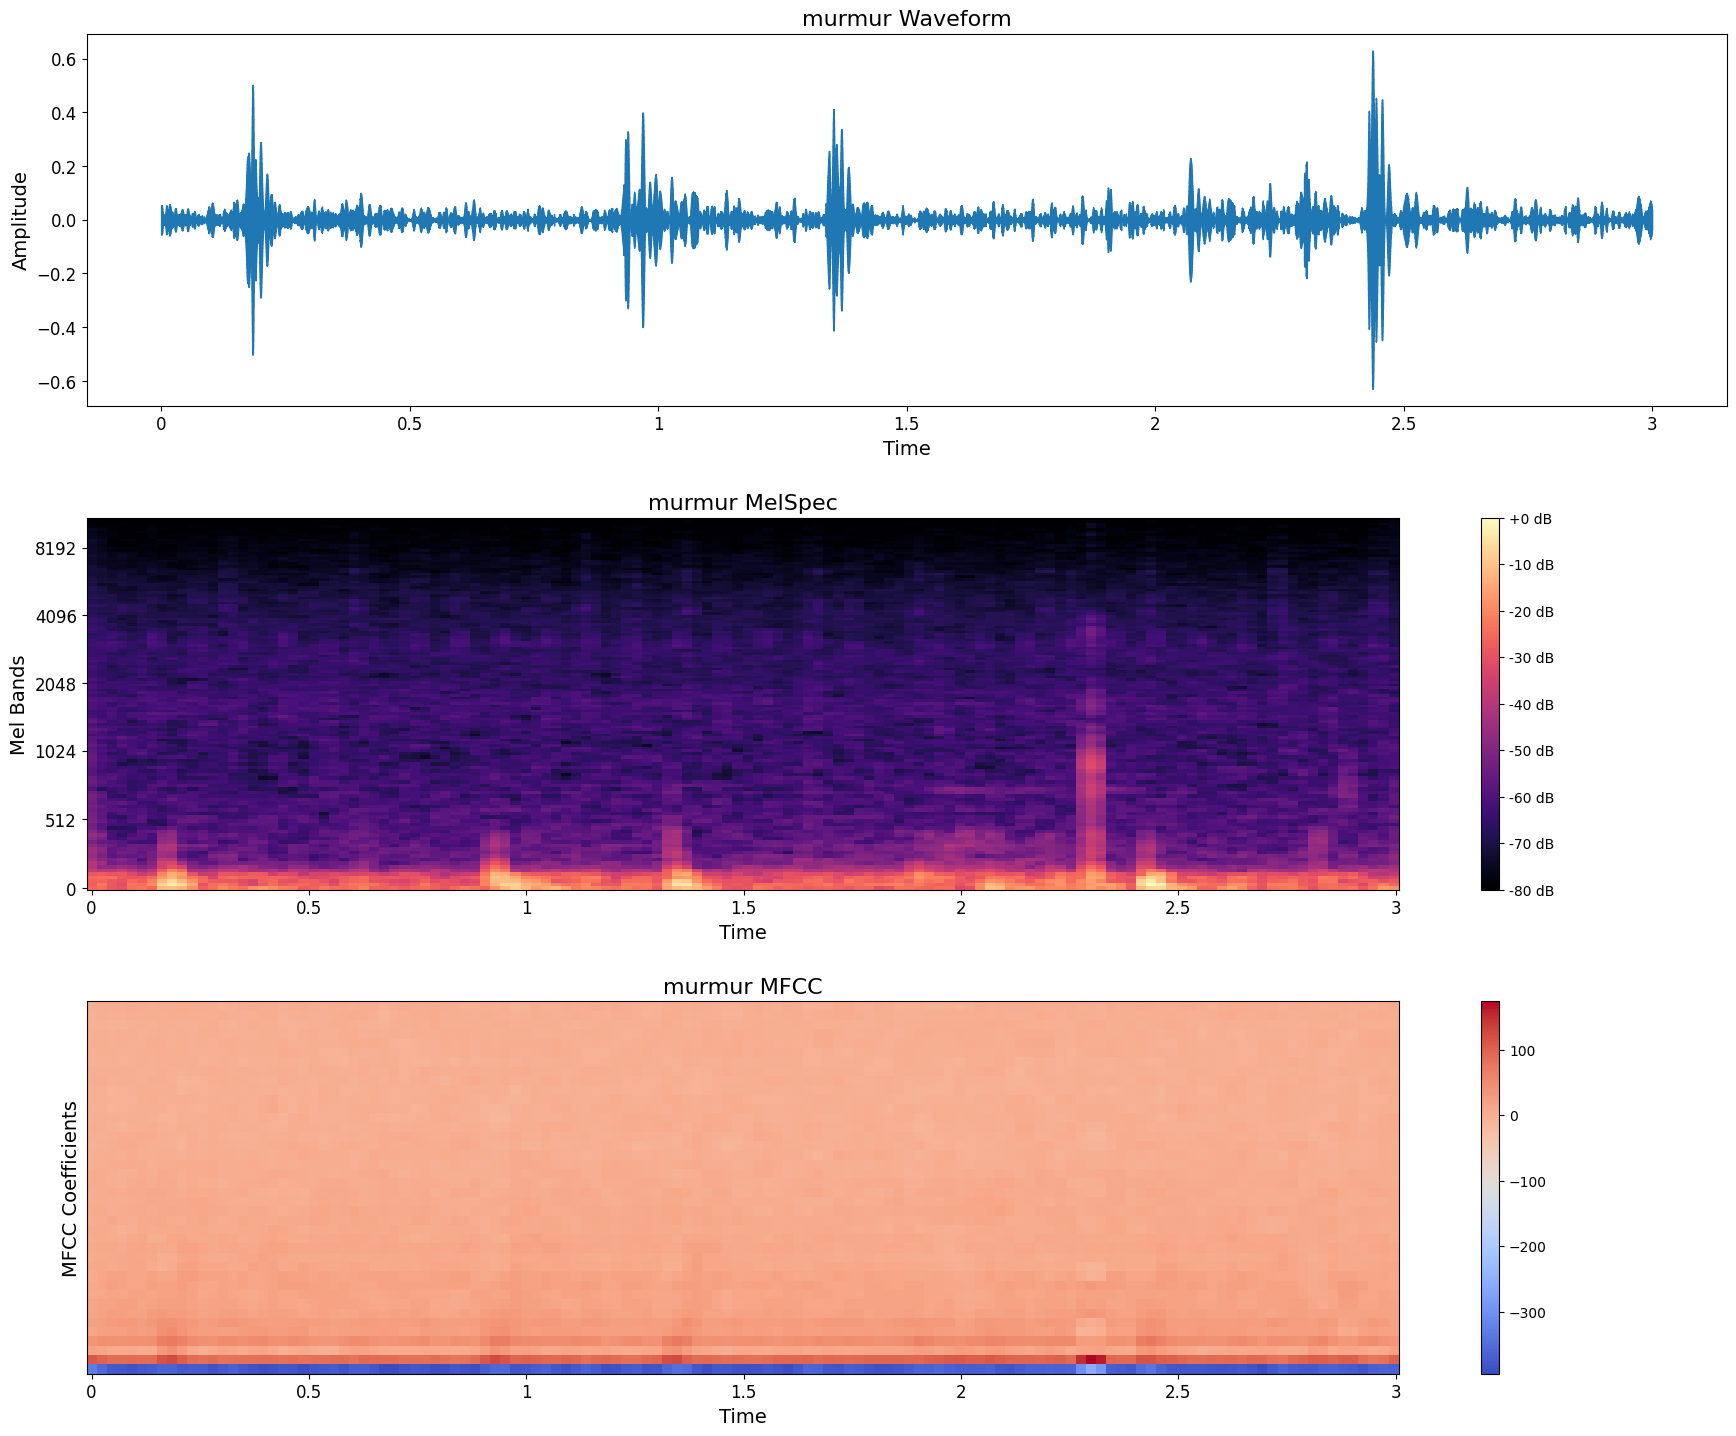

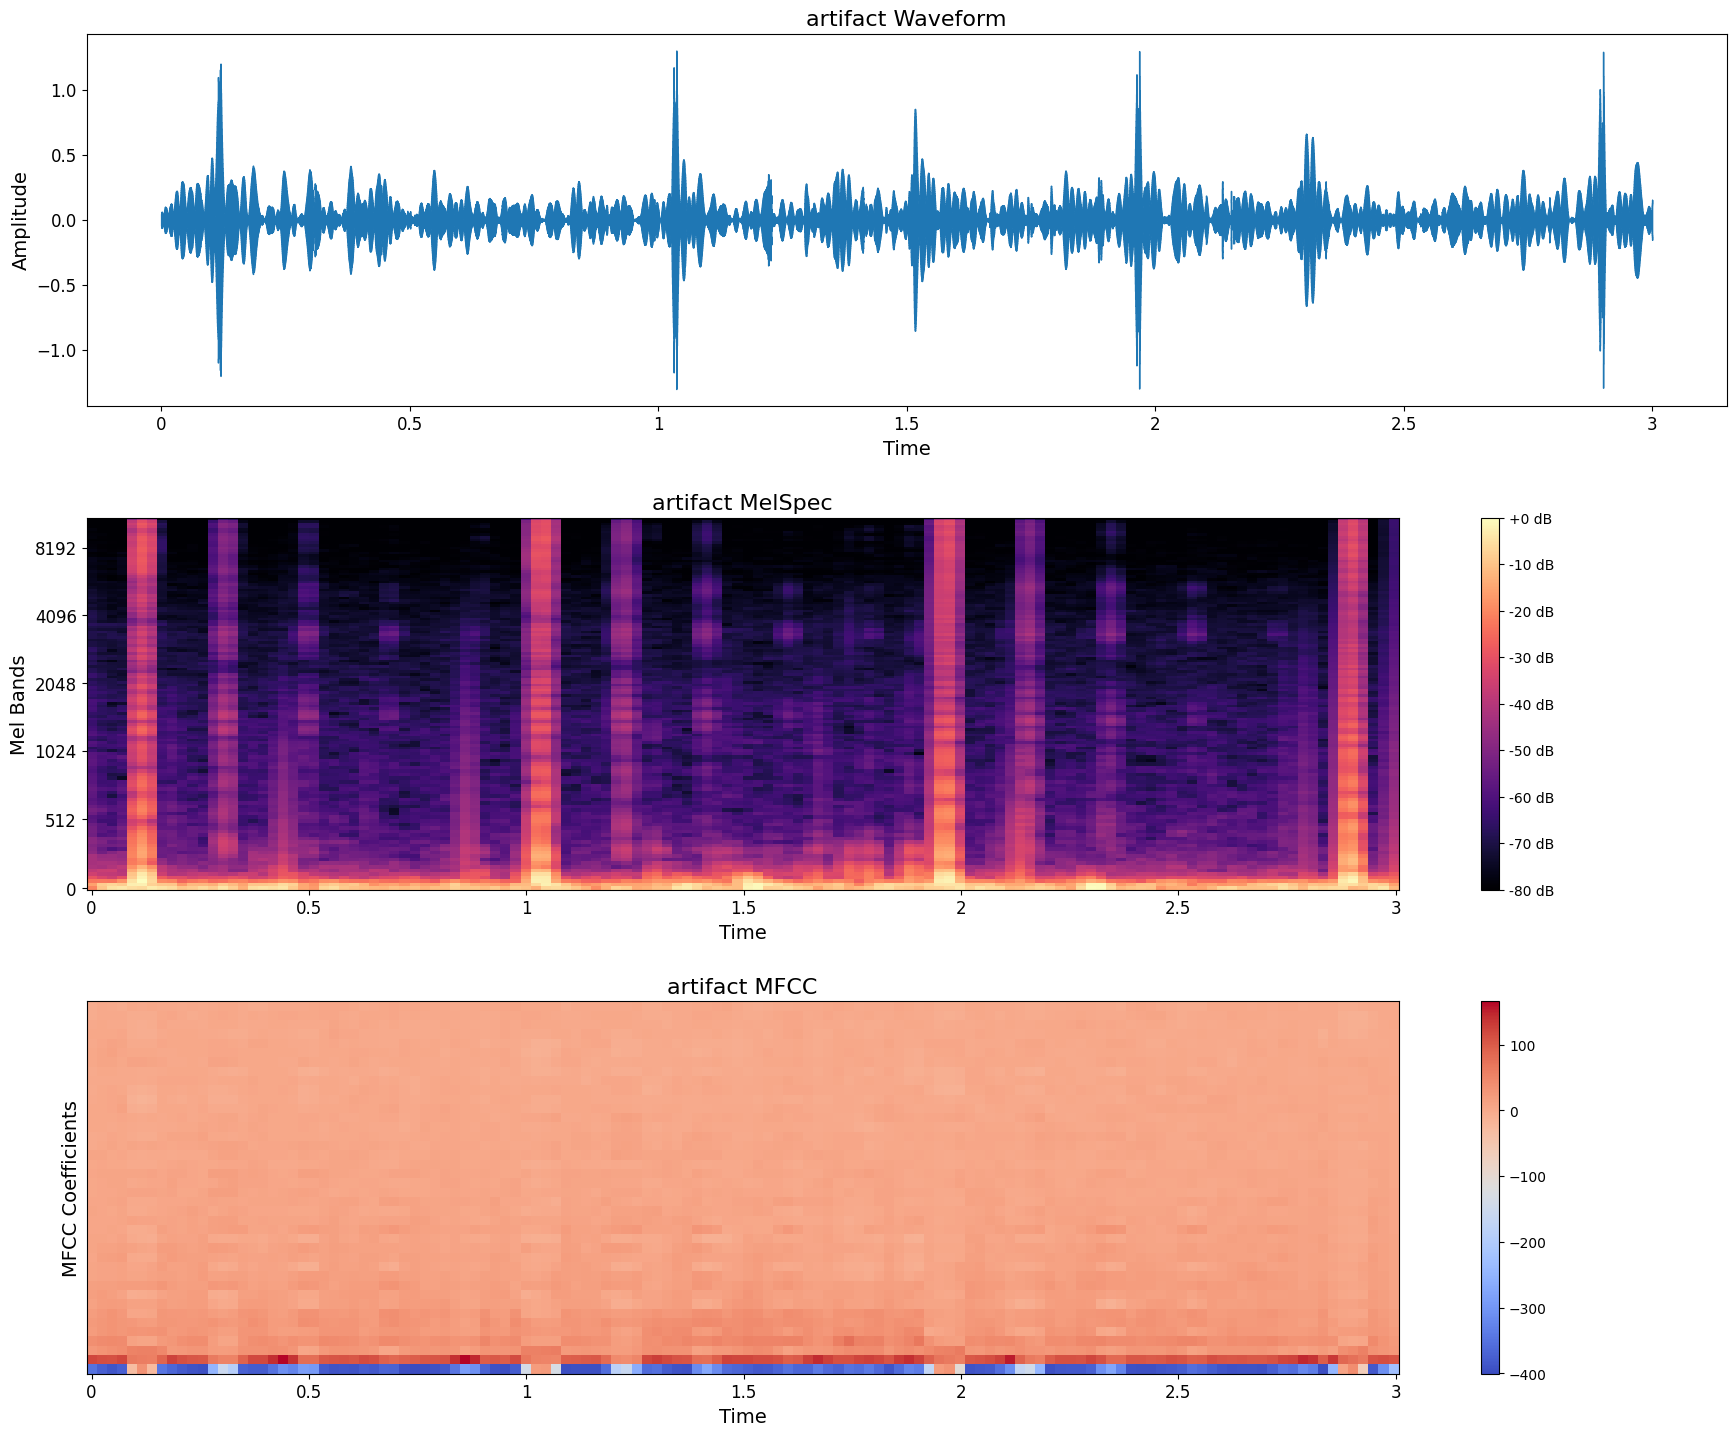

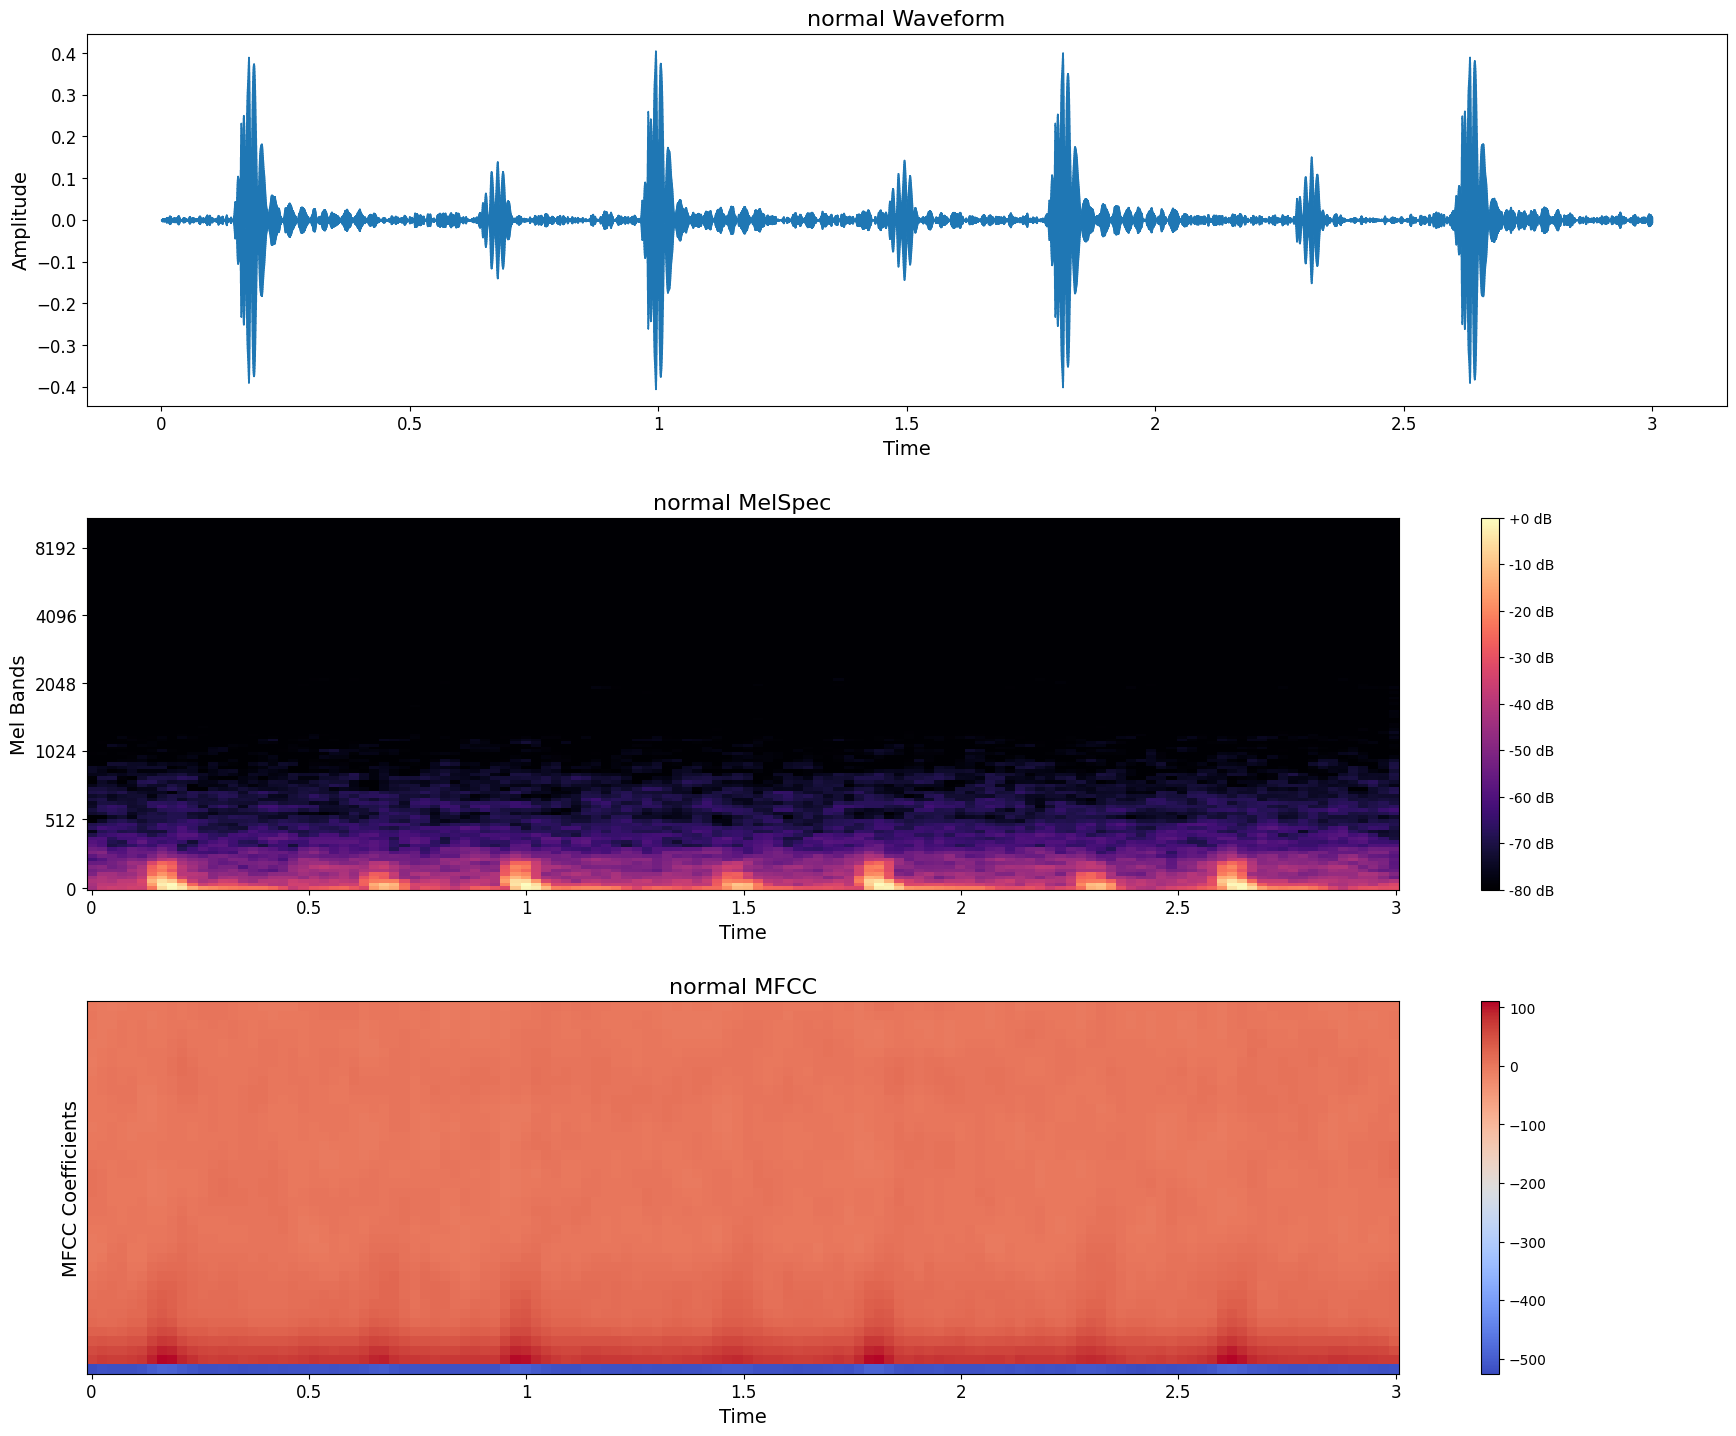

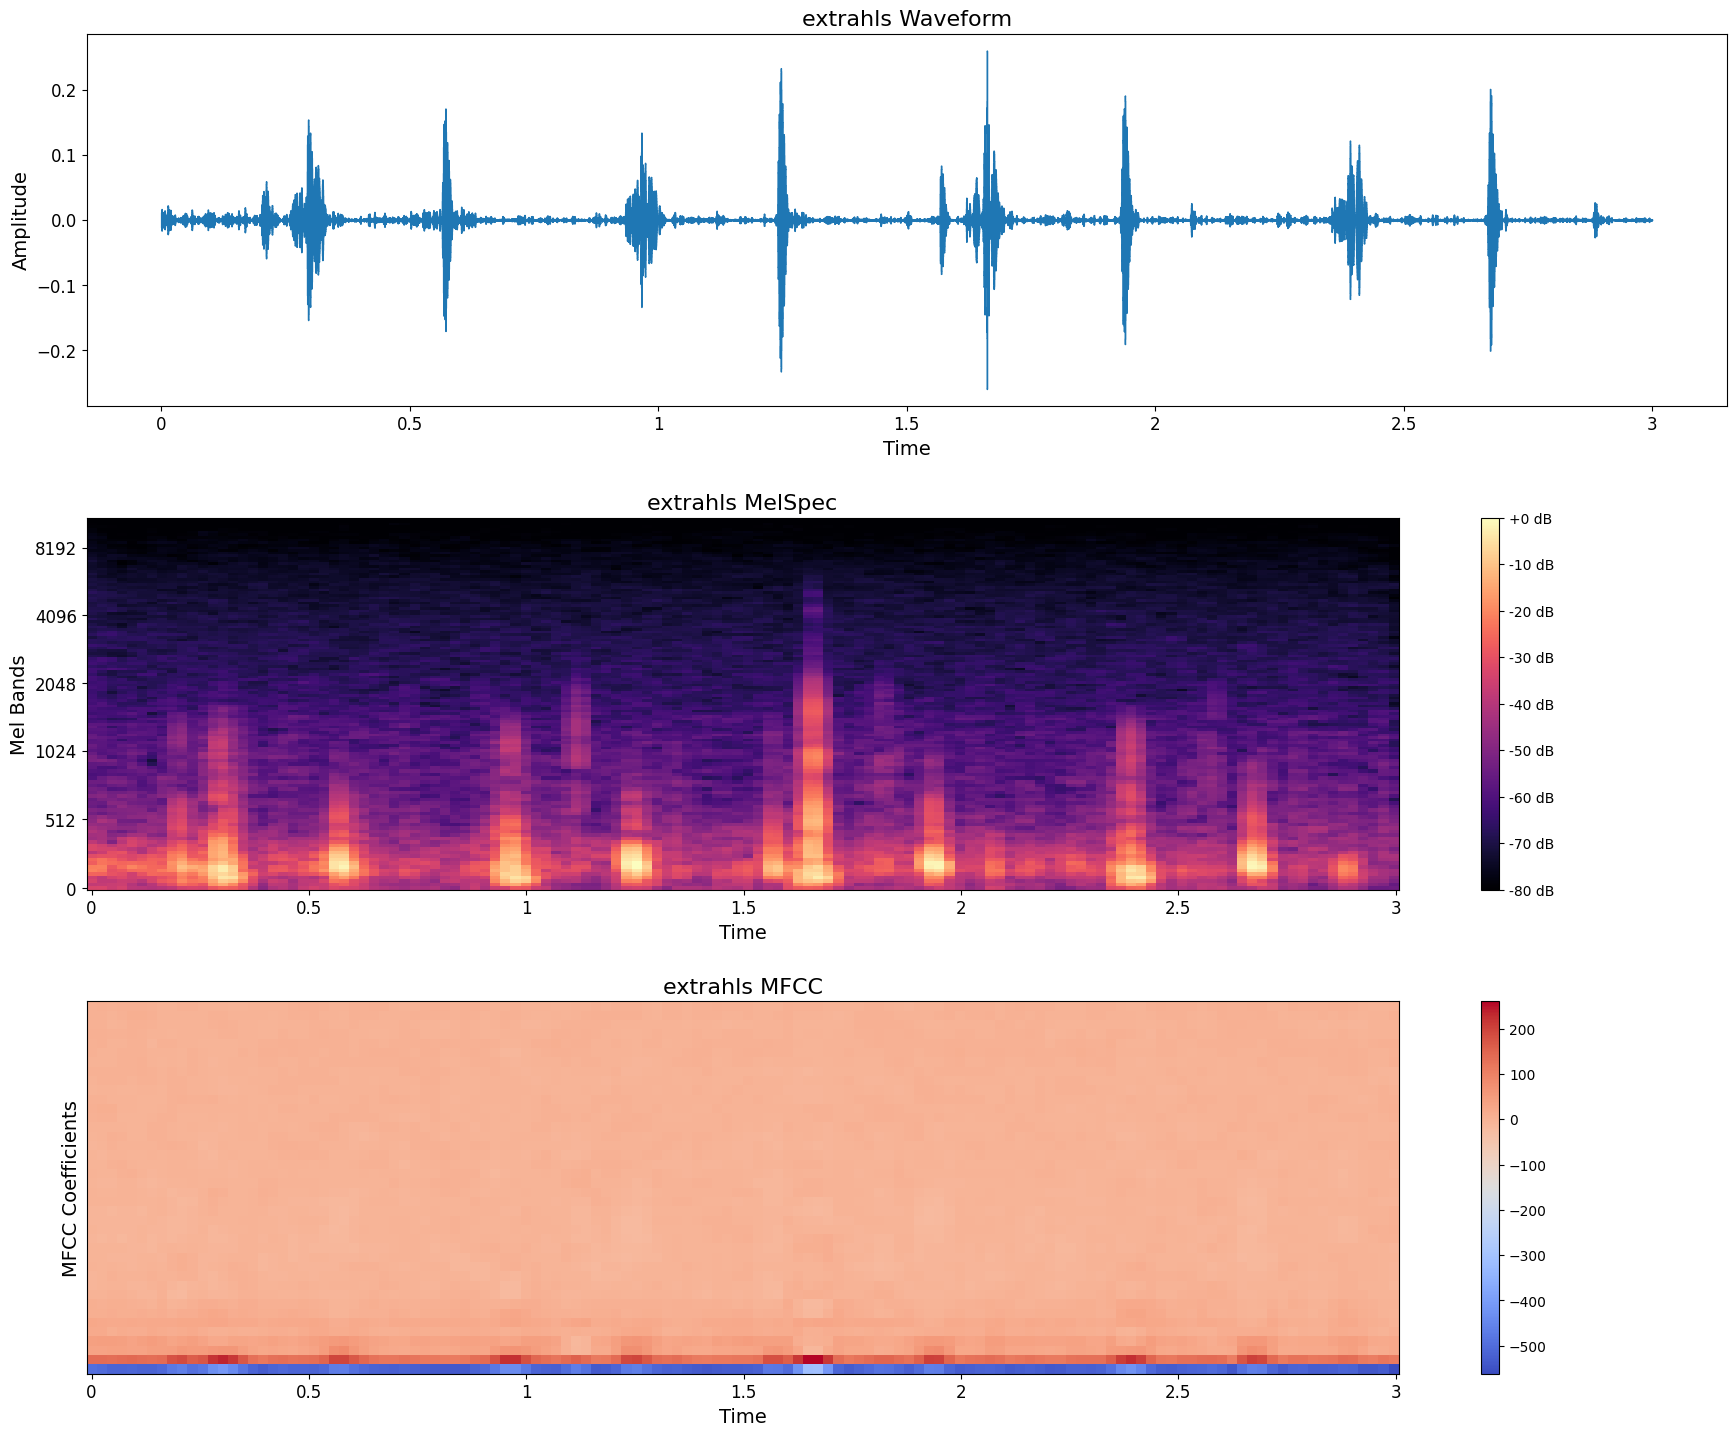

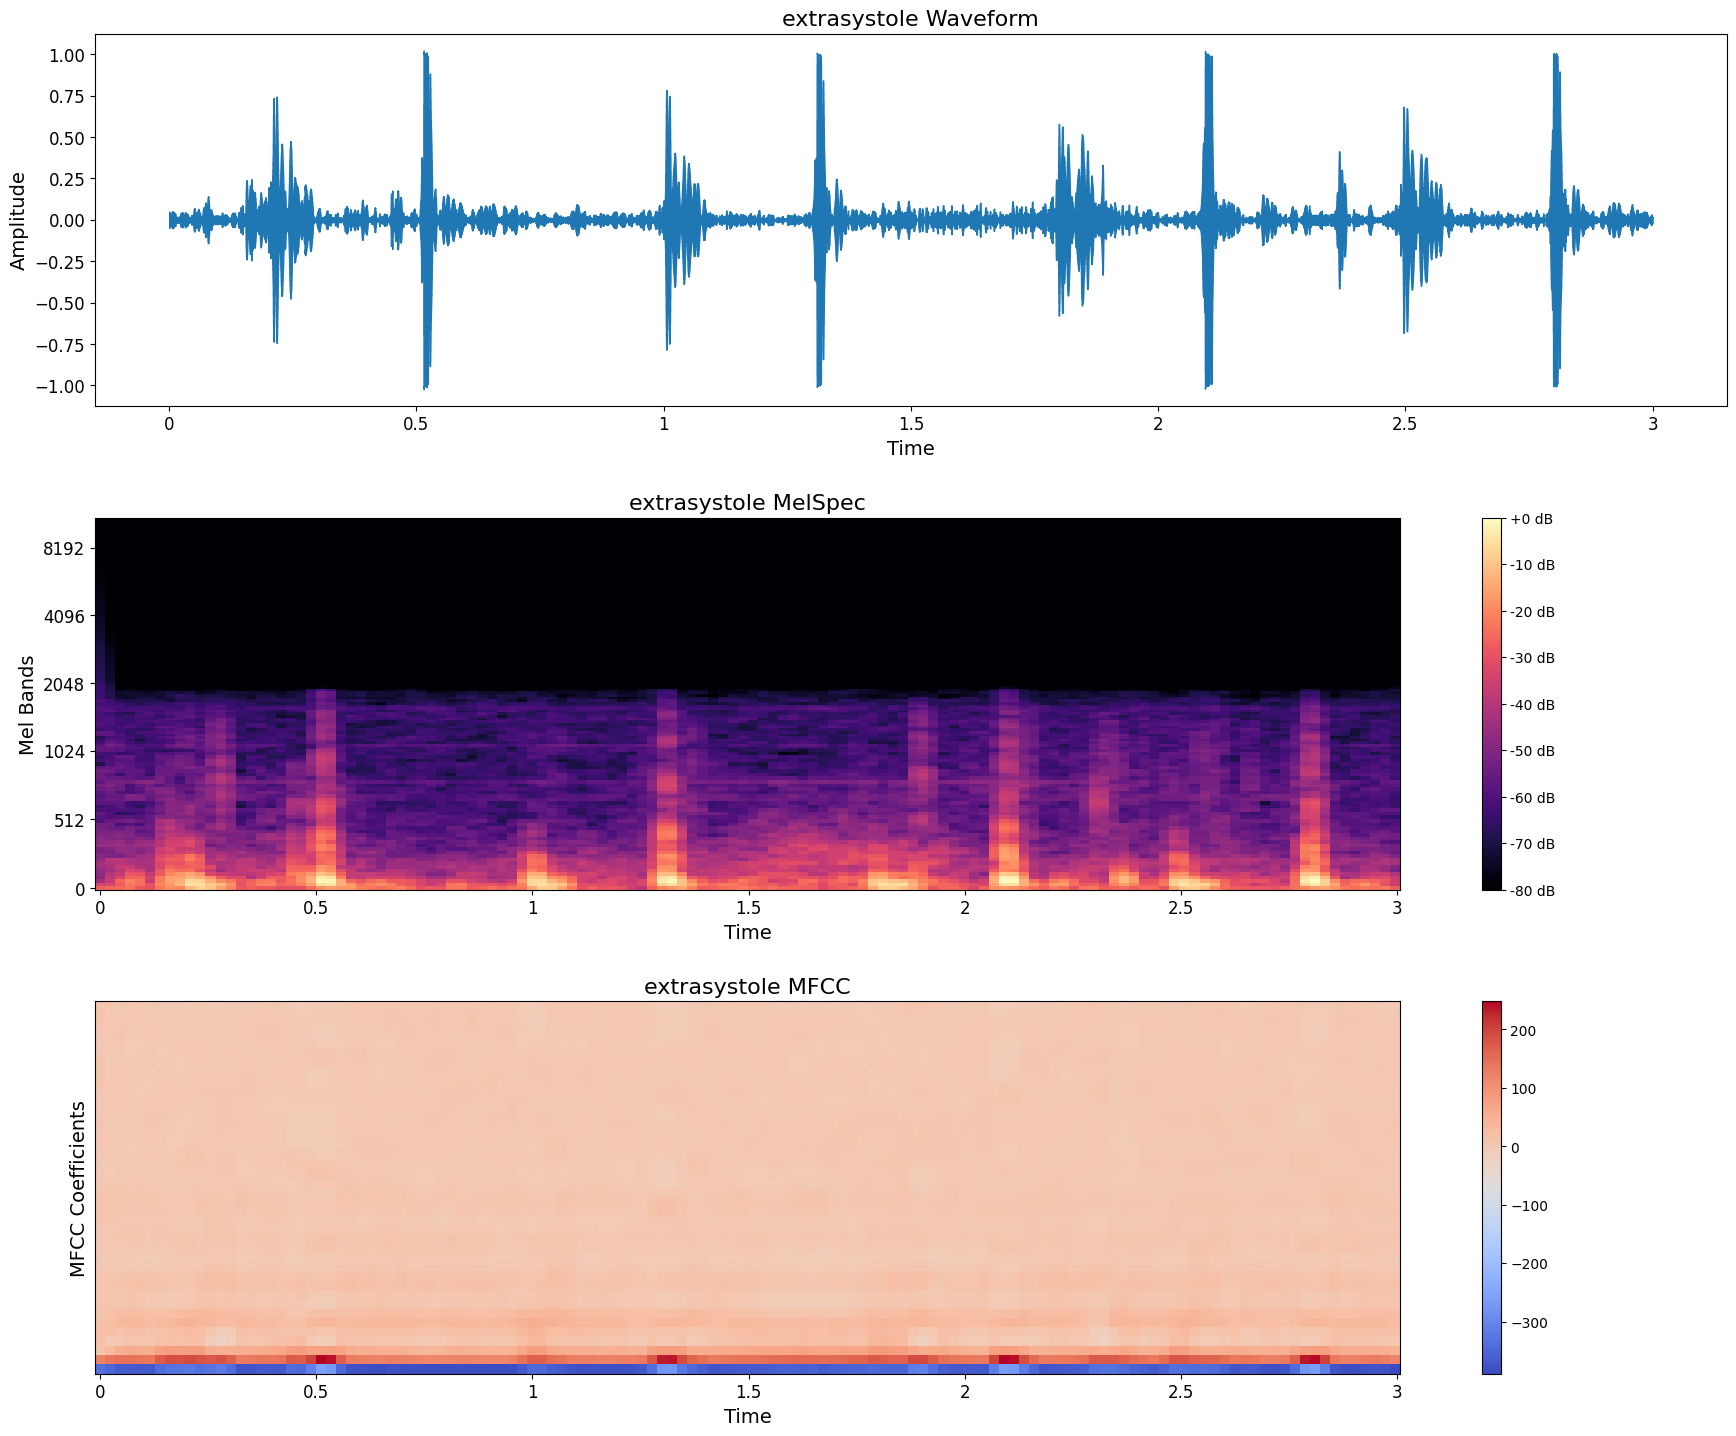

Train: 1571, Test: 393


100%|██████████| 393/393 [00:02<00:00, 178.46it/s]
c:\Users\Admin\Desktop\ai_projects\heartbeat_classifier\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 38, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 17, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 6, 29, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 1, 12, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,381 (1.61 MB)

 Trainable params: 421,381 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2472 - loss: 4.4675
Epoch 1: val_accuracy improved from -inf to 0.29771, saving model to model/heartbeat_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2488 - loss: 4.4259 - val_accuracy: 0.2977 - val_loss: 1.2806
Epoch 2/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4134 - loss: 0.9278
Epoch 2: val_accuracy improved from 0.29771 to 0.53181, saving model to model/heartbeat_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4144 - loss: 0.9275 - val_accuracy: 0.5318 - val_loss: 1.0516
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4697 - loss: 0.9084
Epoch 3: val_accuracy improved from 0.53181 to 0.54453, saving model to model/heartbeat_best.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4706 - loss: 0.9074 - val_accuracy: 0.5445 - val_loss: 1.0116
Epoch 4/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5492 - loss: 0.7777
Epoch 4: val_a

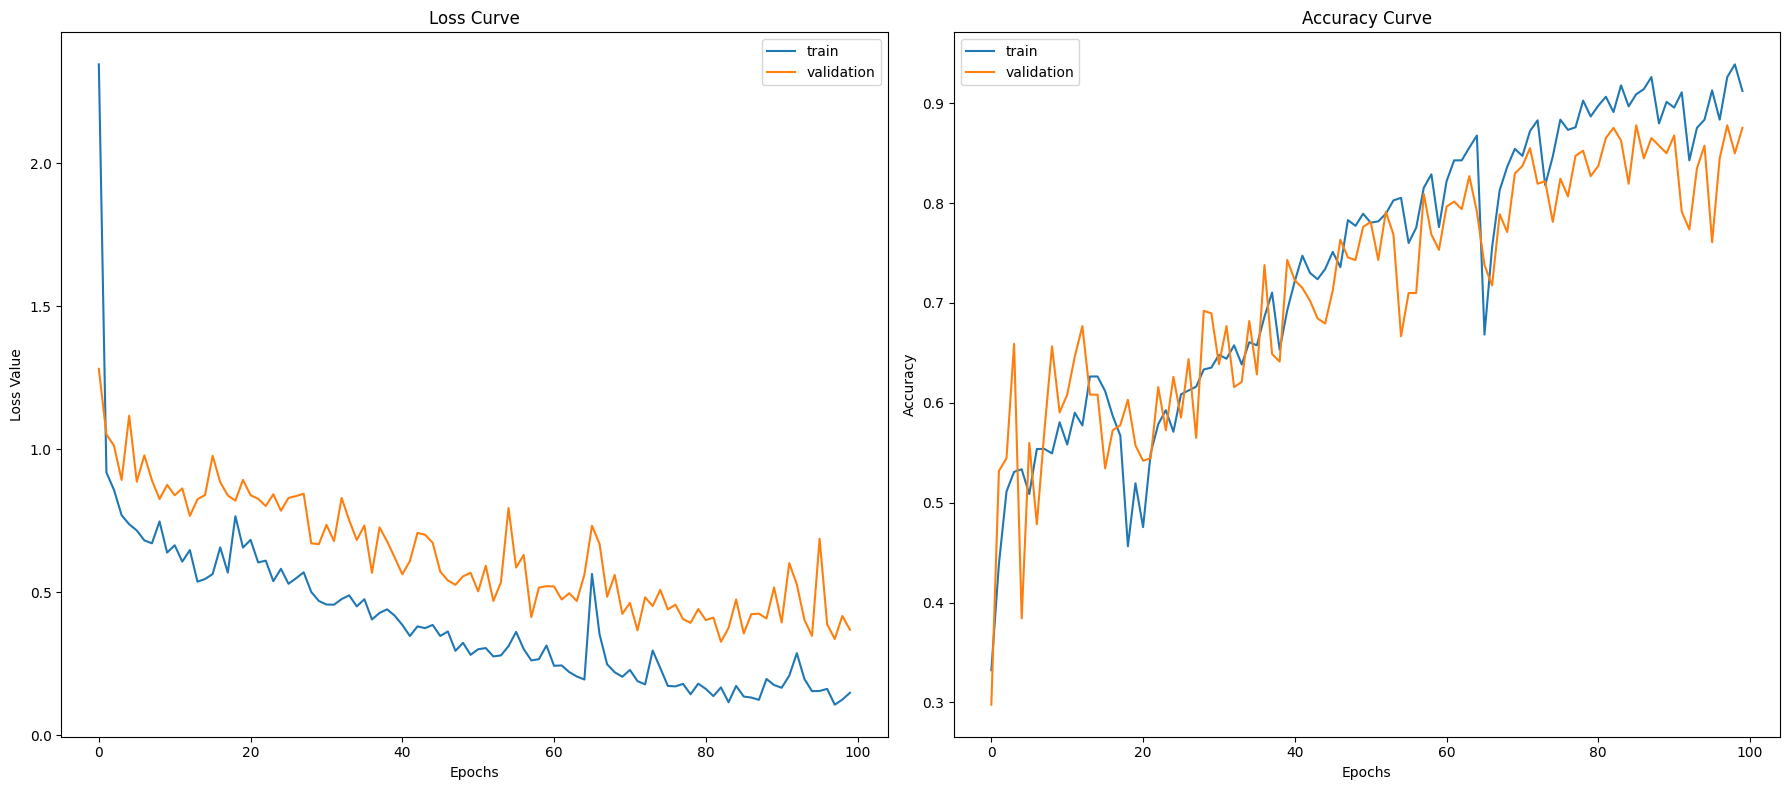

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8906 - loss: 0.3217
Test loss: 0.3259672224521637 Accuracy: 0.8753180503845215
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

    artifact       0.95      1.00      0.98        40
    extrahls       0.62      1.00      0.76        13
extrasystole       0.65      0.83      0.73        24
      murmur       0.83      0.94      0.88        99
      normal       0.95      0.82      0.88       217

    accuracy                           0.88       393
   macro avg       0.80      0.92      0.85       393
weighted avg       0.89      0.88      0.88       393



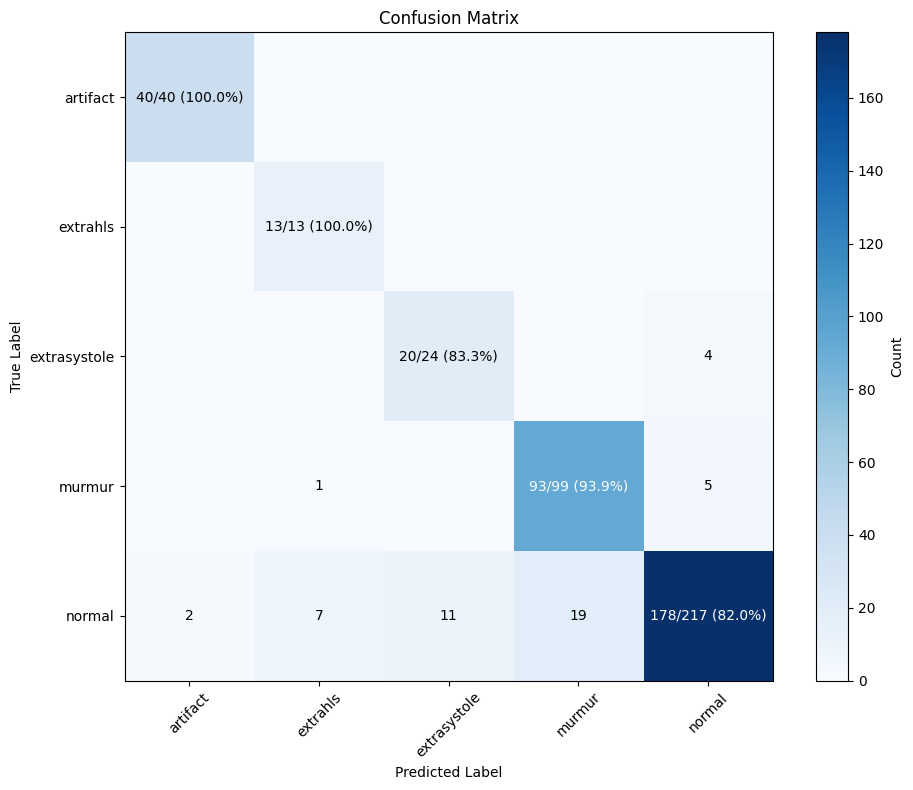

Saved model and class mapping.


In [105]:
if __name__ == "__main__":
    train_model()